# Aprendizaje Profundo
Daniel López Gala - UO281798

Se dispone del conjunto de datos NIPS4BPLUS, el cual contiene 674 ficheros de audio con una duración total de menos de una hora. En estos audios podemos encontrar grabaciones de aproximadamente 5 segundos con cantos de pájaros realizadas en 39 localizaciones diferentes repartidas por 7 regiones de Francia y España.

In [107]:
#base_path = "/content/drive/MyDrive/DeepLearning/"
base_path = ""
DEBUG = True

In [108]:
# from google.colab import drive
# drive.mount('/content/drive')

In [109]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2

import torchaudio
import torchaudio.transforms as T

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import torchvision.models as models

from sklearn.metrics import f1_score

# !pip install scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split

## Preprocesamiento y visualización

- Se define una función `visualize_intermediates` para crear imágenes de los pasos intermedios usados en el preprocesamiento de los audios.

- La clase `AudioPreprocessing` define los pasos para procesar la imagen. Se incluyen:
  - Resample (De 44100Hz a 22050Hz)
  - STFT (Convertir a espectrograma)
  - Normalización
  - Median clipping
  - Conectar puntos cercanos mediante filtros
  - Closing
  - Dilation
  - Median blur
  - Eliminar residuos

In [110]:
def visualize_intermediates(intermediates, sample_rate=44100, hop_length=196):

    # Set default background color for figures to white
    plt.rcParams['figure.facecolor'] = 'white'

    for key, value in intermediates.items():
        if len(value.shape) == 2 and value.shape[1] > 2:  # This indicates a waveform
            plt.figure(figsize=(12, 4))

            # Calculate time axis in seconds for waveform
            time_axis_waveform = np.linspace(0, value.shape[1] / sample_rate, value.shape[1])

            plt.plot(time_axis_waveform, value[0].cpu().numpy())
            plt.xlabel("Time (seconds)")
            plt.title(f"{key}")
            plt.show()
            continue

        print(f"Processing {key} with shape {value.shape}")

        if value.dim() == 4 and value.shape[-1] == 2:
            complex_representation = value[0, ..., 0] + 1j * value[0, ..., 1]  # Convert to complex
            magnitude = torch.abs(complex_representation).cpu().numpy()
            phase = torch.angle(complex_representation).cpu().numpy()
        elif value.is_complex():
            magnitude = torch.abs(value).squeeze().cpu().numpy()
            phase = torch.angle(value).squeeze().cpu().numpy()
        else:
            magnitude = value.squeeze().cpu().numpy()
            phase = None

        # Calculate time axis in seconds for magnitude
        time_axis_magnitude = np.linspace(0, magnitude.shape[1] * hop_length / sample_rate, magnitude.shape[1])

        # Plot magnitude with inverted grayscale colormap
        plt.figure(figsize=(12, 4))
        plt.imshow(magnitude, cmap='gray_r', aspect='auto', origin='lower', extent=[time_axis_magnitude[0], time_axis_magnitude[-1], 0, magnitude.shape[0]])
        plt.xlabel("Time (seconds)")
        plt.title(f"{key} Magnitude")
        plt.colorbar()
        plt.show()

        # Plot phase
        if phase is not None:
            plt.figure(figsize=(12, 4))
            plt.imshow(((phase + np.pi) % (2 * np.pi) - np.pi), cmap='hsv', aspect='auto', origin='lower', vmin=-np.pi, vmax=np.pi, extent=[time_axis_magnitude[0], time_axis_magnitude[-1], 0, phase.shape[0]])
            plt.xlabel("Time (seconds)")
            plt.title(f"{key} Phase")
            plt.colorbar()
            plt.show()


In [111]:
class AudioPreprocessing(nn.Module):
    def __init__(self, debug=DEBUG, sample_rate=44100, n_fft=1024, win_length=1024, hop_length=196):
        super().__init__()
        self.debug = debug
        self.sample_rate = sample_rate
        self.resampler = T.Resample(44100, sample_rate)
        self.spectrogram = T.MelSpectrogram(sample_rate, n_fft=n_fft, win_length=win_length, hop_length=hop_length, f_min=500, f_max=15000)

    def normalize(self, spectrogram):
        min_val = torch.min(spectrogram)
        return (spectrogram - min_val) / (torch.max(spectrogram) - min_val + 1e-5)

    def median_blurring(self, spectrogram):
        img = spectrogram.squeeze(0).cpu().numpy()
        img = cv2.medianBlur(img.astype(np.float32), 3)
        return torch.tensor(img, device=spectrogram.device).float().unsqueeze(0)
        
    def median_filtering(self, spectrogram, threshold=1.5):
        freq_median = torch.median(spectrogram, dim=2, keepdim=True).values
        time_median = torch.median(spectrogram, dim=1, keepdim=True).values
        mask = (spectrogram > threshold * freq_median) & (spectrogram > threshold * time_median)
        return mask.float()

    # def spot_removal(self, spectrogram):
    #     img = spectrogram.squeeze(0).cpu().numpy()
    #     img = cv2.fastNlMeansDenoising(img.astype(np.uint8),None,31,7,21)
    #     return torch.tensor(img, device=spectrogram.device).float().unsqueeze(0)

    def spot_removal(self, spectrogram, threshold=0.1):
        # Threshold the spectrogram to get a binary mask
        binary_mask = (spectrogram > threshold).float()

        # Convert to numpy for morphological operations
        binary_np = binary_mask.squeeze(0).cpu().numpy().astype(np.uint8)

        # Define a kernel for morphological operations (adjust size as needed)
        kernel = np.ones((3, 3), np.uint8)

        # Perform morphological opening to remove small noise
        cleaned_binary_np = cv2.morphologyEx(binary_np, cv2.MORPH_OPEN, kernel)

        # Convert back to tensor
        cleaned_binary_mask = torch.tensor(cleaned_binary_np, device=spectrogram.device).float().unsqueeze(0)

        # Multiply with original spectrogram to remove the noise
        denoised_spectrogram = spectrogram * cleaned_binary_mask

        return denoised_spectrogram


    def morph_closing(self, spectrogram):
        img = spectrogram.squeeze(0).cpu().numpy()
        kernel = np.ones((3, 3), np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        return torch.tensor(img, device=spectrogram.device).float().unsqueeze(0)

    def forward(self, waveform):
        intermediates = {}
        
        # waveform = self.resampler(waveform)
        spectrogram = self.spectrogram(waveform)
        if self.debug: intermediates['original_spectrograms'] = spectrogram

        spectrogram = self.normalize(spectrogram)
        spectrogram = self.median_blurring(spectrogram)
        if self.debug: intermediates['spectrograms_after_median_blurring'] = spectrogram

        spectrogram = self.median_filtering(spectrogram)
        if self.debug: intermediates['spectrograms_after_median_filtering'] = spectrogram

        # spectrogram = self.spot_removal(spectrogram)
        # if self.debug: intermediates['spectrograms_after_spot_removal'] = spectrogram

        spectrogram = self.morph_closing(spectrogram)
        if self.debug: intermediates['spectrograms_after_morph_closing'] = spectrogram
        
        if not self.debug:
            # If debug is False, return empty intermediates
            return spectrogram, {}

        return (spectrogram, intermediates)

## Carga de datos

Se leen los audios de forma individual. Cada audio es un objeto. `BirdSongDataset` define el método `__getitem__` para obtener cada instancia del dataset.

No se tiene en cuenta en qué momento del audio suena cada pájaro, tan sólo qué pájaros suenan en cada audio. El problema se plantea como **clasificación multietiqueta**.

El método `get_class_proportions` se utiliza para comprobar que los datasets *train* y *validation* contienen la misma proporción de clases, es decir, están estratíficados.

In [112]:
class BirdSongDataset(Dataset):
    def __init__(self, df, audio_dir, class_info, transform=None):
        segments = []

        unique_filenames = df['filename'].unique()  # Only process each audio file once
        for unique_filename in unique_filenames:
            audio_path = os.path.join(audio_dir, unique_filename)
            waveform, sample_rate = torchaudio.load(audio_path)
            total_segments = int(math.ceil(waveform.shape[1] / sample_rate))  # Total segments in the audio

            # Calculate the unique labels for each segment
            for idx in range(total_segments):
                start_time, end_time = idx, idx + 1
                labels_in_segment = df[(df['filename'] == unique_filename) & 
                                       (df['end'] > start_time) & 
                                       (df['start'] < end_time)]['class'].unique().tolist()
                segments.append({
                    'filename': unique_filename, 
                    'segment_idx': idx, 
                    'start': start_time, 
                    'end': end_time,
                    'class': ",".join(labels_in_segment)
                })

        self.segments = pd.DataFrame(segments)
        self.audio_dir = audio_dir
        self.class_info = class_info
        self.transform = transform

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        row = self.segments.iloc[idx]
        audio_path = os.path.join(self.audio_dir, row['filename'])
        waveform, sample_rate = torchaudio.load(audio_path)

        # Extract 1-second segment
        start_sample = int(row['start'] * sample_rate)
        end_sample = int(row['end'] * sample_rate)
        waveform = waveform[:, start_sample:end_sample]

        # Padding if needed
        if waveform.shape[1] < sample_rate:
            num_padding = sample_rate - waveform.shape[1]
            waveform = torch.cat([waveform, torch.zeros(1, num_padding)], dim=1)

        class_names = row['class'].split(",") if row['class'] else []
        target = torch.zeros(len(self.class_info))
        for class_name in class_names:
            target[self.class_info.index(class_name)] = 1.0

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, target

    def get_filename(self, idx):
        return self.segments.iloc[idx]['filename']


train_csv = pd.read_csv(f'{base_path}data/train.csv') # CSV with train audio filenames, and bird class names labels.
class_info_csv = pd.read_csv(f'{base_path}data/class_info.csv')
class_names = class_info_csv['class name'].tolist()

# Convert the labels to a binary matrix form
y = np.zeros((len(train_csv), len(class_names)))
for i, (_, row) in enumerate(train_csv.iterrows()):
    labels = row['class'].split(",")
    for label in labels:
        y[i, class_names.index(label)] = 1

X_train, y_train, X_val, y_val = iterative_train_test_split(np.array(train_csv), y, test_size=0.08)

train_df = pd.DataFrame(X_train, columns=train_csv.columns)
valid_df = pd.DataFrame(X_val, columns=train_csv.columns)

transform = nn.Sequential(
    AudioPreprocessing()
)

train_dataset = BirdSongDataset(train_df, f'{base_path}data/train/', class_names, transform=transform)
valid_dataset = BirdSongDataset(valid_df, f'{base_path}data/train/', class_names, transform=transform)


In [113]:
def aggregate_predictions(predictions, segments_df):
    aggregated_predictions = {}
    for filename in segments_df['filename'].unique():
        aggregated_predictions[filename] = set()
        segments = segments_df[segments_df['filename'] == filename]
        for idx, row in segments.iterrows():
            aggregated_predictions[filename].update(predictions[idx])
    return aggregated_predictions


In [114]:
specific_audio_segments = train_dataset.segments[train_dataset.segments['filename'] == 'nips4b_train001.wav']
print(specific_audio_segments)

              filename  segment_idx  start  end                    class
0  nips4b_train001.wav            0      0    1              Sylcan_song
1  nips4b_train001.wav            1      1    2  Sylcan_song,Petpet_song
2  nips4b_train001.wav            2      2    3  Petpet_song,Sylcan_song
3  nips4b_train001.wav            3      3    4              Petpet_song
4  nips4b_train001.wav            4      4    5                         
5  nips4b_train001.wav            5      5    6                         


In [115]:
# Assuming you want to listen to the 3rd segment
segment_idx = 2
waveform, label = train_dataset[segment_idx]
print(f"Label: {label}")

# Convert tensor label back to class names
predicted_classes = [class_name for idx, class_name in enumerate(class_names) if label[idx] == 1.0]

print("Predicted Classes:", predicted_classes)

Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Predicted Classes: ['Petpet_song', 'Sylcan_song']


In [116]:
def get_class_proportions(y, class_names):
    """
    Calculate the proportion of each class in the given binary matrix y.
    """
    proportions = {}
    total_samples = y.shape[0]

    for idx, class_name in enumerate(class_names):
        proportions[class_name] = np.sum(y[:, idx]) / total_samples

    return proportions


if DEBUG:
    train_proportions = get_class_proportions(y_train, class_names)
    valid_proportions = get_class_proportions(y_val, class_names)

    print("Class Proportions in Training Dataset:")
    for class_name, proportion in train_proportions.items():
        print(f"{class_name}: {proportion * 100:.2f}%")

    print("\nClass Proportions in Validation Dataset:")
    for class_name, proportion in valid_proportions.items():
        print(f"{class_name}: {proportion * 100:.2f}%")

    # Comparing the differences in proportions
    print("\nDifferences in Proportions (Training - Validation):")
    for class_name in class_names:
        difference = train_proportions[class_name] - valid_proportions[class_name]
        print(f"{class_name}: {difference * 100:.2f}%")


Class Proportions in Training Dataset:
Aegcau_call: 0.62%
Alaarv_song: 2.86%
Anttri_song: 2.25%
Butbut_call: 0.38%
Carcan_call: 1.25%
Carcan_song: 1.73%
Carcar_call: 1.56%
Carcar_song: 2.67%
Cerbra_call: 0.54%
Cerbra_song: 0.36%
Cetcet_song: 2.72%
Chlchl_call: 0.38%
Cicatr_song: 0.14%
Cicorn_song: 0.19%
Cisjun_song: 0.47%
Colpal_song: 0.83%
Corcor_call: 0.38%
Denmaj_call: 0.47%
Denmaj_drum: 0.40%
Embcir_call: 0.71%
Embcir_song: 0.92%
Erirub_call: 0.78%
Erirub_song: 1.54%
Fricoe_call: 0.43%
Fricoe_song: 1.16%
Galcri_call: 0.80%
Galcri_song: 0.88%
Galthe_call: 0.26%
Galthe_song: 2.51%
Gargla_call: 0.26%
Hirrus_call: 0.36%
Jyntor_song: 0.19%
Lopcri_call: 0.92%
Loxcur_call: 1.44%
Lularb_song: 3.81%
Lusmeg_call: 0.73%
Lusmeg_song: 1.92%
Lyrple_song: 0.28%
Motcin_call: 1.23%
Musstr_call: 0.38%
Noise: 1.82%
Oriori_call: 0.28%
Oriori_song: 0.88%
Parate_call: 0.66%
Parate_song: 1.89%
Parcae_call: 1.63%
Parcae_song: 1.42%
Parmaj_call: 0.76%
Parmaj_song: 2.44%
Pasdom_call: 1.35%
Pelgra_call: 0.50

Number of elements: 649
torch.Size([1, 128, 226])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Number of positive labels: 1.0
Predicted Classes: ['Sylcan_song']
Processing original_spectrograms with shape torch.Size([1, 128, 226])


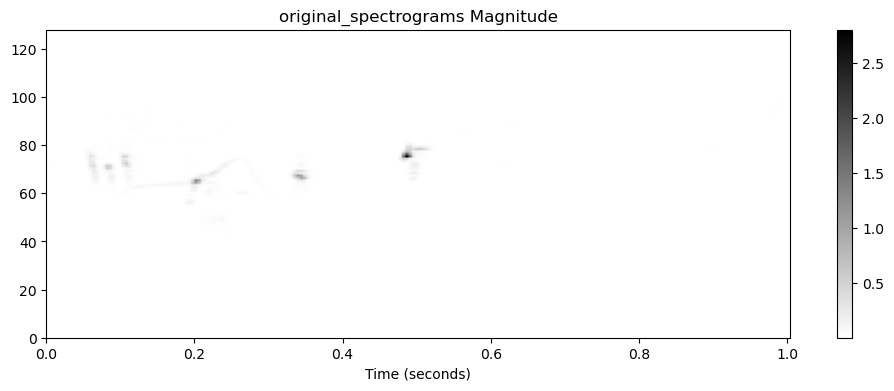

Processing spectrograms_after_median_blurring with shape torch.Size([1, 128, 226])


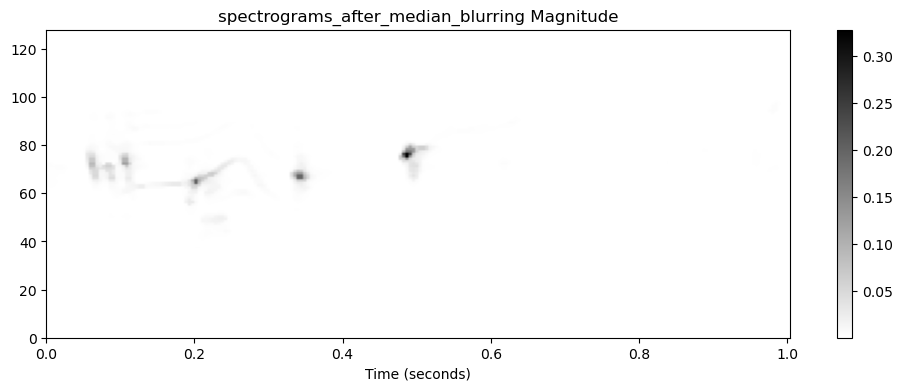

Processing spectrograms_after_median_filtering with shape torch.Size([1, 128, 226])


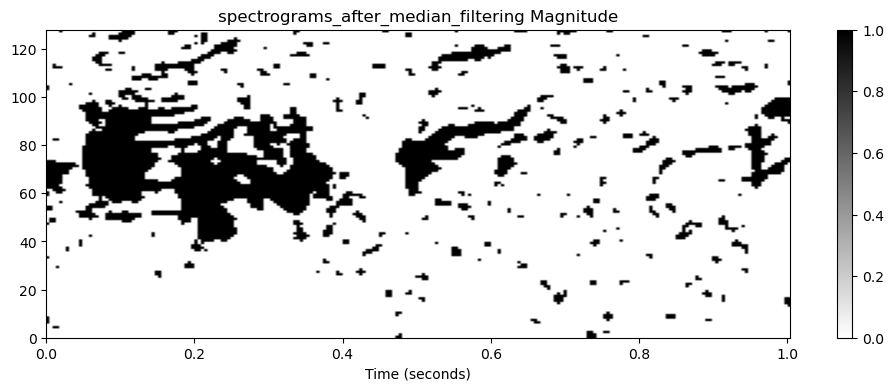

Processing spectrograms_after_morph_closing with shape torch.Size([1, 128, 226])


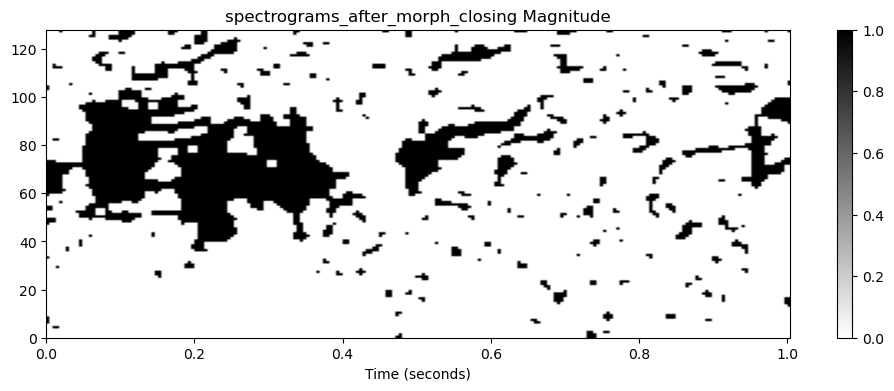

In [117]:
if DEBUG:
    print(f"Number of elements: {len(valid_dataset)}")
    sample, target = valid_dataset[1]
    processed_sample, intermediates = sample

    print(processed_sample.shape)
    num_positive_labels = target.sum().item()
    print(target)
    print(f"Number of positive labels: {num_positive_labels}")

    predicted_classes = [class_name for idx, class_name in enumerate(class_names) if target[idx] == 1.0]
    print("Predicted Classes:", predicted_classes)

    visualize_intermediates(intermediates)

Number of elements: 2584
torch.Size([1, 128, 226])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Number of positive labels: 1.0
Predicted Classes: ['Cetcet_song']
Processing original_spectrograms with shape torch.Size([1, 128, 226])


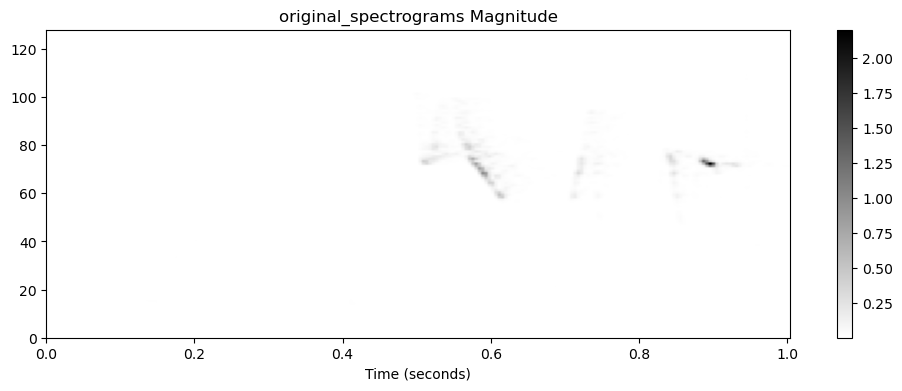

Processing spectrograms_after_median_blurring with shape torch.Size([1, 128, 226])


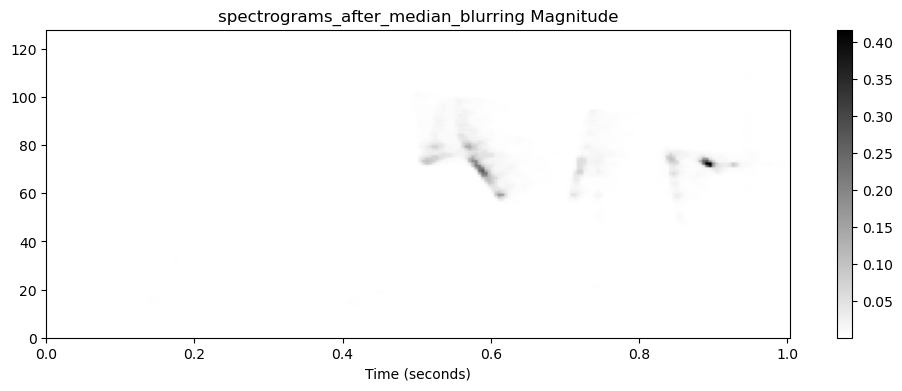

Processing spectrograms_after_median_filtering with shape torch.Size([1, 128, 226])


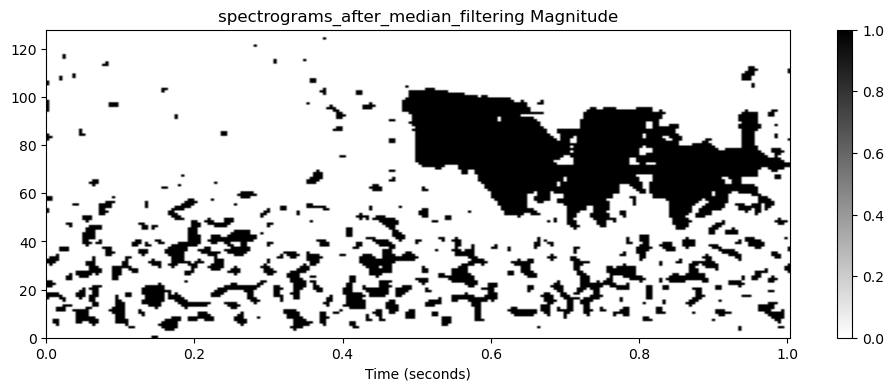

Processing spectrograms_after_morph_closing with shape torch.Size([1, 128, 226])


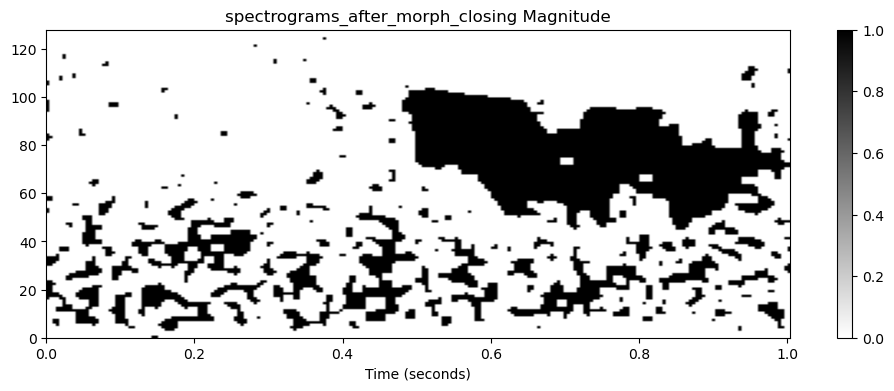

In [118]:
if DEBUG:
    print(f"Number of elements: {len(train_dataset)}")
    sample, target = train_dataset[80]
    processed_sample, intermediates = sample

    print(processed_sample.shape)
    num_positive_labels = target.sum().item()
    print(target)
    print(f"Number of positive labels: {num_positive_labels}")

    predicted_classes = [class_name for idx, class_name in enumerate(class_names) if target[idx] == 1.0]
    print("Predicted Classes:", predicted_classes)

    visualize_intermediates(intermediates)

**Calcular la longitud máxima de las formas de onda**

Se determina la longitud máxima entre todas las formas de onda para poder rellenar (padding) o truncar los audios posteriormente, garantizando que todos tengan la misma longitud.

La función `collate_fn` se utiliza para procesar y combinar un lote (batch) de muestras en el dataloader. Asegura que todas las formas de onda tengan la misma longitud (rellenando con ceros si es necesario) y devuelve las formas de onda junto con sus objetivos (etiquetas). Para esto, necesita la longitud máxima calculada anteriormente.

In [119]:
def collate_fn(batch):
    # Check the nature of the second element in the tuple to determine the scenario
    
    # Extract the waveform (or spectrogram) and ignore intermediates if they exist
    waveforms_or_spectrograms = [wf[0] if isinstance(wf, tuple) else wf for wf, _ in batch]
    
    if isinstance(batch[0][1], str): 
        # This handles the Test set scenario where targets might be filenames
        waveforms_or_spectrograms = torch.stack(waveforms_or_spectrograms)
        _, filenames = zip(*batch)
        return waveforms_or_spectrograms, filenames
    
    elif isinstance(batch[0][1], dict):
        # This handles the scenario where DEBUG is False and intermediates dictionary is returned
        waveforms_or_spectrograms = torch.stack(waveforms_or_spectrograms)
        return waveforms_or_spectrograms  # Note: Here we return only the waveforms as there are no target labels
    
    else:
        # This handles the Training or validation batch scenario
        waveforms_or_spectrograms = torch.stack(waveforms_or_spectrograms)
        _, targets = zip(*batch)
        targets = torch.stack(targets)
        return waveforms_or_spectrograms, targets

BATCH_SIZE=64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


## Definición del modelo

- Se define una arquitectura basada en el modelo ResNet50 preentrenado.
- Se adapta la primera capa convolucional para aceptar imágenes de un solo canal (grises).
- Se elimina la última capa completamente conectada del ResNet y se agrega una clasificación personalizada para adaptar la arquitectura al problema multietiqueta.

Se utiliza una mezcla de *transfer-learning* y *fine-tuning*.

**Transferencia de aprendizaje**:

El modelo se carga y se adaptan algunas capas. Se congelan los pesos de las capas del modelo preentrenado para que no se actualicen durante el entrenamiento inicial, por lo que sólo las capas personalizadas, como la capa de clasificación, se entrenarán. Es decir, se adapta a una tarea diferente el modelo, manteniendo los pesos originales.

**Fine-tuning**:

Después de algunas épocas de entrenamiento determinadas en el código se desbloquean las capas del modelo preentrenado para que sus pesos también puedan actualizarse durante el entrenamiento

```python
if epoch == X:
    for param in model.features.parameters():
        param.requires_grad = True
```

Este fine-tuning ajusta el modelo a los datos específicos para mejorar el rendimiento, aunque causa cierto *overfitting* al sobreescribir los pesos originales con los datos de entrenamiento.




In [120]:
class ResNetMultilabel(nn.Module):
    def __init__(self, num_classes, layers_to_unfreeze=None):
        super(ResNetMultilabel, self).__init__()

        # Initialize the pre-trained model
        self.resnet = models.resnet18(pretrained=True)
        
        # Replace the initial conv layer to handle grayscale images
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Modify the final layer to match the number of classes
        fc_input_size = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(fc_input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

        if not layers_to_unfreeze:
            layers_to_unfreeze = ["layer3", "layer4", "avgpool", "fc"]

        # Unfreeze selected layers for fine-tuning
        for name, child in self.resnet.named_children():
            if layers_to_unfreeze == "all" or name in layers_to_unfreeze:
                for _, params in child.named_parameters():
                    params.requires_grad = True
            else:
                for _, params in child.named_parameters():
                    params.requires_grad = False
                    
    def forward(self, x):
        return self.resnet(x)

In [121]:
# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

# Initialize the model
# model = ResNetMultilabel(num_classes=len(class_names), layers_to_unfreeze="all").to(device)
model = ResNetMultilabel(num_classes=len(class_names)).to(device)

Using: cuda


c:\Users\danil\.conda\envs\pytorch-gpu-python-3-10\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\danil\.conda\envs\pytorch-gpu-python-3-10\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Entrenamiento

- Se utiliza BCE (Binary Cross Entropy), adecuada para problemas de clasificación multietiqueta junto a un optimizador Adam con las tasas de aprendizaje diferentes para cada fase del entrenamiento.
- Se utiliza un programador de learning rate (ReduceLROnPlateau) que disminuye la tasa de aprendizaje si la función de pérdida no mejora.

El proceso de entrenamiento se ejecuta a través de 20 épocas, y durante cada época se calcula la pérdida en entrenamiento y se ajustan los pesos del modelo, se calcula el F1 en entrenamiento, y se pasa el modelo a modo de evaluación para evaluar en el conjunto de validación, calculando tanto la pérdida como el F1 score.

Si el modelo mejora (en F1) se guarda un checkpoint de los pesos. Está implementada, aunque no se usa actualmente, una lógica de early-stop para evitar el sobreajuste.

Después de cada época se ajusta el learning rate según la evolución de la pérdida en validación.

**Búsqueda de umbral**:
- Se inicializa una lista de posibles `thresholds` de 0.1 a 1 en incrementos de 0.1. Estos son los umbrales para decidir si una predicción (probabilidad) del modelo es positiva o negativa.
- Para cada umbral se calcula el F1 score en entrenamiento y validación y se elige el umbral que produce el mejor F1 score en el conjunto de validación.

Esto es importante porque las salidas del modelo son valores continuos entre 0 y 1, que representan la confianza del modelo en que esa etiqueta es positiva, y es necesario decidir un umbral (`threshold`) para convertir estas salidas continuas en etiquetas binarias definitivas.

In [122]:
total_epochs = 25

# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Optimizer with L2 regularization
criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
# scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 4
early_stop = False
thresholds = np.arange(0.1, 1, 0.1)

for epoch in range(total_epochs):

    # Training
    model.train()
    running_train_loss = 0.0
    all_train_preds = []
    all_train_labels = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Store training predictions and true labels
        all_train_preds.extend(outputs.detach().cpu().numpy().tolist())
        all_train_labels.extend(labels.cpu().numpy().tolist())

    train_loss = running_train_loss / len(train_loader)

    # Validation
    model.eval()
    running_val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            # Store predictions and true labels
            all_preds.extend(outputs.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    val_loss = running_val_loss / len(valid_loader)

    # Append losses to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Calculate validation F1 scores over different thresholds
    val_f1_scores = []
    for threshold in thresholds:
        val_f1_scores.append(f1_score(all_labels, np.array(all_preds) > threshold, average='samples', zero_division=1))

    # Get the best F1 score and corresponding threshold from the validation data
    best_threshold_index_val = np.argmax(val_f1_scores)
    best_threshold_val = thresholds[best_threshold_index_val]
    validation_f1 = val_f1_scores[best_threshold_index_val]

    # Calculate training F1 score using the best_threshold_val
    train_best_f1 = f1_score(all_train_labels, np.array(all_train_preds) > best_threshold_val, average='samples', zero_division=1)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Training F1: {train_best_f1:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {validation_f1:.4f} using threshold {best_threshold_val:.2f}")

    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        early_stop = True
        break

    # Adjusting learning rate
    scheduler.step(-val_loss)

if early_stop:
    print("Stopped training. Loading best model weights!")
    model.load_state_dict(torch.load('best_model.pth'))

print('Finished Training')

Epoch 1, Train Loss: 0.3727, Training F1: 0.3576, Validation Loss: 0.0966, Validation F1: 0.5300 using threshold 0.30
Epoch 2, Train Loss: 0.0652, Training F1: 0.4029, Validation Loss: 0.0358, Validation F1: 0.5131 using threshold 0.20
Epoch 3, Train Loss: 0.0544, Training F1: 0.2829, Validation Loss: 0.0339, Validation F1: 0.5131 using threshold 0.40
Epoch 4, Train Loss: 0.0510, Training F1: 0.3177, Validation Loss: 0.0347, Validation F1: 0.5146 using threshold 0.30
Epoch 5, Train Loss: 0.0473, Training F1: 0.3248, Validation Loss: 0.0329, Validation F1: 0.5300 using threshold 0.40
Epoch 6, Train Loss: 0.0443, Training F1: 0.3751, Validation Loss: 0.0302, Validation F1: 0.5331 using threshold 0.30
Epoch 7, Train Loss: 0.0414, Training F1: 0.3655, Validation Loss: 0.0292, Validation F1: 0.5193 using threshold 0.60
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.
Epoch 8, Train Loss: 0.0374, Training F1: 0.6435, Validation Loss: 0.0279, Validation F1: 0.5561 using threshold

Notas:

Sin weight_decay, sin preprocesamiento (sólo espectograma):
```
Epoch 1, Train Loss: 0.2575, Training F1: 0.3691, Validation Loss: 0.0432, Validation F1: 0.5146 using threshold 0.30
Epoch 2, Train Loss: 0.0581, Training F1: 0.2927, Validation Loss: 0.0347, Validation F1: 0.5162 using threshold 0.30
Epoch 3, Train Loss: 0.0547, Training F1: 0.2643, Validation Loss: 0.0337, Validation F1: 0.5208 using threshold 0.80
Epoch 4, Train Loss: 0.0518, Training F1: 0.3185, Validation Loss: 0.0326, Validation F1: 0.5300 using threshold 0.30
Epoch 5, Train Loss: 0.0480, Training F1: 0.3553, Validation Loss: 0.0310, Validation F1: 0.5352 using threshold 0.30
Epoch 6, Train Loss: 0.0443, Training F1: 0.6381, Validation Loss: 0.0319, Validation F1: 0.5501 using threshold 0.10
Epoch 7, Train Loss: 0.0418, Training F1: 0.5144, Validation Loss: 0.0293, Validation F1: 0.5747 using threshold 0.20
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.
Epoch 8, Train Loss: 0.0372, Training F1: 0.6800, Validation Loss: 0.0264, Validation F1: 0.5741 using threshold 0.10
Epoch 9, Train Loss: 0.0337, Training F1: 0.7075, Validation Loss: 0.0260, Validation F1: 0.5747 using threshold 0.10
Epoch 10, Train Loss: 0.0310, Training F1: 0.7119, Validation Loss: 0.0264, Validation F1: 0.5635 using threshold 0.10
Epoch 11, Train Loss: 0.0288, Training F1: 0.6770, Validation Loss: 0.0255, Validation F1: 0.5612 using threshold 0.20
Epoch 12, Train Loss: 0.0264, Training F1: 0.6627, Validation Loss: 0.0259, Validation F1: 0.5607 using threshold 0.30
Epoch 13, Train Loss: 0.0239, Training F1: 0.6987, Validation Loss: 0.0255, Validation F1: 0.6134 using threshold 0.30
Epoch 00013: reducing learning rate of group 0 to 2.5000e-05.
Epoch 14, Train Loss: 0.0217, Training F1: 0.6900, Validation Loss: 0.0263, Validation F1: 0.6113 using threshold 0.40
Epoch 15, Train Loss: 0.0199, Training F1: 0.7212, Validation Loss: 0.0262, Validation F1: 0.6018 using threshold 0.40
Epoch 16, Train Loss: 0.0189, Training F1: 0.7487, Validation Loss: 0.0266, Validation F1: 0.6085 using threshold 0.40
Epoch 17, Train Loss: 0.0174, Training F1: 0.6633, Validation Loss: 0.0266, Validation F1: 0.6099 using threshold 0.60
Early stopping!
Stopped training. Loading best model weights!
Finished Training
```

Con preprocesamiento:
```
Epoch 1, Train Loss: 0.2724, Training F1: 0.3399, Validation Loss: 0.0381, Validation F1: 0.5162 using threshold 0.20
Epoch 2, Train Loss: 0.0586, Training F1: 0.2651, Validation Loss: 0.0394, Validation F1: 0.5162 using threshold 0.50
Epoch 3, Train Loss: 0.0546, Training F1: 0.3727, Validation Loss: 0.0359, Validation F1: 0.5316 using threshold 0.20
Epoch 4, Train Loss: 0.0507, Training F1: 0.3197, Validation Loss: 0.0341, Validation F1: 0.5239 using threshold 0.50
Epoch 5, Train Loss: 0.0481, Training F1: 0.4107, Validation Loss: 0.0347, Validation F1: 0.5300 using threshold 0.20
Epoch 6, Train Loss: 0.0453, Training F1: 0.4669, Validation Loss: 0.0308, Validation F1: 0.5439 using threshold 0.20
Epoch 7, Train Loss: 0.0425, Training F1: 0.3636, Validation Loss: 0.0324, Validation F1: 0.5270 using threshold 0.70
Epoch 8, Train Loss: 0.0397, Training F1: 0.4856, Validation Loss: 0.0310, Validation F1: 0.5326 using threshold 0.30
Epoch 00008: reducing learning rate of group 0 to 5.0000e-05.
Epoch 9, Train Loss: 0.0351, Training F1: 0.7184, Validation Loss: 0.0276, Validation F1: 0.5813 using threshold 0.10
Epoch 10, Train Loss: 0.0318, Training F1: 0.5607, Validation Loss: 0.0285, Validation F1: 0.5542 using threshold 0.40
Epoch 11, Train Loss: 0.0297, Training F1: 0.6984, Validation Loss: 0.0281, Validation F1: 0.5642 using threshold 0.20
Epoch 12, Train Loss: 0.0274, Training F1: 0.6582, Validation Loss: 0.0283, Validation F1: 0.5783 using threshold 0.30
Epoch 13, Train Loss: 0.0262, Training F1: 0.7359, Validation Loss: 0.0274, Validation F1: 0.5689 using threshold 0.20
Epoch 14, Train Loss: 0.0255, Training F1: 0.6927, Validation Loss: 0.0289, Validation F1: 0.5665 using threshold 0.30
Epoch 00014: reducing learning rate of group 0 to 2.5000e-05.
Epoch 15, Train Loss: 0.0232, Training F1: 0.7313, Validation Loss: 0.0274, Validation F1: 0.5829 using threshold 0.30
Epoch 16, Train Loss: 0.0209, Training F1: 0.8032, Validation Loss: 0.0273, Validation F1: 0.5770 using threshold 0.20
Epoch 17, Train Loss: 0.0196, Training F1: 0.7766, Validation Loss: 0.0273, Validation F1: 0.5996 using threshold 0.30
Epoch 18, Train Loss: 0.0189, Training F1: 0.7359, Validation Loss: 0.0279, Validation F1: 0.5752 using threshold 0.40
Epoch 19, Train Loss: 0.0184, Training F1: 0.8118, Validation Loss: 0.0274, Validation F1: 0.5912 using threshold 0.30
Epoch 20, Train Loss: 0.0179, Training F1: 0.8043, Validation Loss: 0.0275, Validation F1: 0.5774 using threshold 0.30
Early stopping!
Stopped training. Loading best model weights!
Finished Training
```

Con dropout de 0.4
```
Epoch 1, Train Loss: 0.3847, Training F1: 0.3678, Validation Loss: 0.1073, Validation F1: 0.5146 using threshold 0.30
Epoch 2, Train Loss: 0.0695, Training F1: 0.3368, Validation Loss: 0.0351, Validation F1: 0.5162 using threshold 0.30
Epoch 3, Train Loss: 0.0569, Training F1: 0.2922, Validation Loss: 0.0337, Validation F1: 0.5208 using threshold 0.40
Epoch 4, Train Loss: 0.0536, Training F1: 0.2771, Validation Loss: 0.0337, Validation F1: 0.5223 using threshold 0.60
Epoch 5, Train Loss: 0.0512, Training F1: 0.3217, Validation Loss: 0.0347, Validation F1: 0.5254 using threshold 0.30
Epoch 6, Train Loss: 0.0487, Training F1: 0.2984, Validation Loss: 0.0328, Validation F1: 0.5239 using threshold 0.70
Epoch 7, Train Loss: 0.0454, Training F1: 0.3571, Validation Loss: 0.0313, Validation F1: 0.5331 using threshold 0.40
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.
Epoch 8, Train Loss: 0.0425, Training F1: 0.3885, Validation Loss: 0.0294, Validation F1: 0.5408 using threshold 0.40
Epoch 9, Train Loss: 0.0400, Training F1: 0.4480, Validation Loss: 0.0289, Validation F1: 0.5383 using threshold 0.30
Epoch 10, Train Loss: 0.0380, Training F1: 0.4140, Validation Loss: 0.0291, Validation F1: 0.5378 using threshold 0.50
Epoch 11, Train Loss: 0.0364, Training F1: 0.4034, Validation Loss: 0.0281, Validation F1: 0.5393 using threshold 0.60
Epoch 12, Train Loss: 0.0341, Training F1: 0.7057, Validation Loss: 0.0271, Validation F1: 0.5714 using threshold 0.10
Epoch 13, Train Loss: 0.0321, Training F1: 0.5189, Validation Loss: 0.0270, Validation F1: 0.5460 using threshold 0.40
Epoch 00013: reducing learning rate of group 0 to 2.5000e-05.
Epoch 14, Train Loss: 0.0297, Training F1: 0.6692, Validation Loss: 0.0264, Validation F1: 0.5601 using threshold 0.20
Epoch 15, Train Loss: 0.0282, Training F1: 0.7623, Validation Loss: 0.0265, Validation F1: 0.5837 using threshold 0.10
Epoch 16, Train Loss: 0.0271, Training F1: 0.7114, Validation Loss: 0.0264, Validation F1: 0.5778 using threshold 0.20
Epoch 17, Train Loss: 0.0259, Training F1: 0.7281, Validation Loss: 0.0257, Validation F1: 0.5873 using threshold 0.20
Epoch 18, Train Loss: 0.0250, Training F1: 0.7524, Validation Loss: 0.0262, Validation F1: 0.5737 using threshold 0.20
Epoch 19, Train Loss: 0.0239, Training F1: 0.7687, Validation Loss: 0.0256, Validation F1: 0.5799 using threshold 0.20
Epoch 00019: reducing learning rate of group 0 to 1.2500e-05.
Epoch 20, Train Loss: 0.0230, Training F1: 0.7828, Validation Loss: 0.0257, Validation F1: 0.5773 using threshold 0.20
Epoch 21, Train Loss: 0.0222, Training F1: 0.7970, Validation Loss: 0.0259, Validation F1: 0.5760 using threshold 0.20
Epoch 22, Train Loss: 0.0216, Training F1: 0.7987, Validation Loss: 0.0259, Validation F1: 0.5824 using threshold 0.20
Epoch 23, Train Loss: 0.0212, Training F1: 0.8089, Validation Loss: 0.0255, Validation F1: 0.5827 using threshold 0.20
Epoch 24, Train Loss: 0.0204, Training F1: 0.8246, Validation Loss: 0.0258, Validation F1: 0.5840 using threshold 0.20
Epoch 25, Train Loss: 0.0203, Training F1: 0.8189, Validation Loss: 0.0259, Validation F1: 0.5839 using threshold 0.20
Epoch 00025: reducing learning rate of group 0 to 6.2500e-06.
Finished Training
```

Preprocesando, pero sin quitar ruido:
```
Epoch 1, Train Loss: 0.3779, Training F1: 0.4549, Validation Loss: 0.0932, Validation F1: 0.5146 using threshold 0.40
Epoch 2, Train Loss: 0.0656, Training F1: 0.4263, Validation Loss: 0.0351, Validation F1: 0.5146 using threshold 0.20
Epoch 3, Train Loss: 0.0548, Training F1: 0.3765, Validation Loss: 0.0332, Validation F1: 0.5239 using threshold 0.20
Epoch 4, Train Loss: 0.0511, Training F1: 0.3082, Validation Loss: 0.0331, Validation F1: 0.5223 using threshold 0.40
Epoch 5, Train Loss: 0.0481, Training F1: 0.3442, Validation Loss: 0.0312, Validation F1: 0.5357 using threshold 0.30
Epoch 6, Train Loss: 0.0444, Training F1: 0.3729, Validation Loss: 0.0300, Validation F1: 0.5501 using threshold 0.30
Epoch 7, Train Loss: 0.0416, Training F1: 0.6241, Validation Loss: 0.0303, Validation F1: 0.5699 using threshold 0.10
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.
Epoch 8, Train Loss: 0.0377, Training F1: 0.4674, Validation Loss: 0.0274, Validation F1: 0.5547 using threshold 0.30
Epoch 9, Train Loss: 0.0351, Training F1: 0.6887, Validation Loss: 0.0264, Validation F1: 0.5764 using threshold 0.10
Epoch 10, Train Loss: 0.0326, Training F1: 0.6199, Validation Loss: 0.0274, Validation F1: 0.5565 using threshold 0.20
Epoch 11, Train Loss: 0.0305, Training F1: 0.7135, Validation Loss: 0.0264, Validation F1: 0.5899 using threshold 0.10
Epoch 12, Train Loss: 0.0285, Training F1: 0.6162, Validation Loss: 0.0261, Validation F1: 0.5663 using threshold 0.30
Epoch 13, Train Loss: 0.0263, Training F1: 0.7064, Validation Loss: 0.0251, Validation F1: 0.5835 using threshold 0.20
Epoch 00013: reducing learning rate of group 0 to 2.5000e-05.
Epoch 14, Train Loss: 0.0240, Training F1: 0.7563, Validation Loss: 0.0255, Validation F1: 0.6112 using threshold 0.20
Epoch 15, Train Loss: 0.0224, Training F1: 0.7261, Validation Loss: 0.0252, Validation F1: 0.5917 using threshold 0.30
Epoch 16, Train Loss: 0.0215, Training F1: 0.7443, Validation Loss: 0.0250, Validation F1: 0.6073 using threshold 0.30
Epoch 17, Train Loss: 0.0203, Training F1: 0.8168, Validation Loss: 0.0247, Validation F1: 0.6089 using threshold 0.20
Epoch 18, Train Loss: 0.0195, Training F1: 0.7792, Validation Loss: 0.0251, Validation F1: 0.6007 using threshold 0.30
Epoch 19, Train Loss: 0.0185, Training F1: 0.7951, Validation Loss: 0.0258, Validation F1: 0.5924 using threshold 0.30
Epoch 00019: reducing learning rate of group 0 to 1.2500e-05.
Epoch 20, Train Loss: 0.0176, Training F1: 0.7575, Validation Loss: 0.0254, Validation F1: 0.6017 using threshold 0.40
Epoch 21, Train Loss: 0.0170, Training F1: 0.7691, Validation Loss: 0.0254, Validation F1: 0.5981 using threshold 0.40
Early stopping!
Stopped training. Loading best model weights!
Finished Training
```

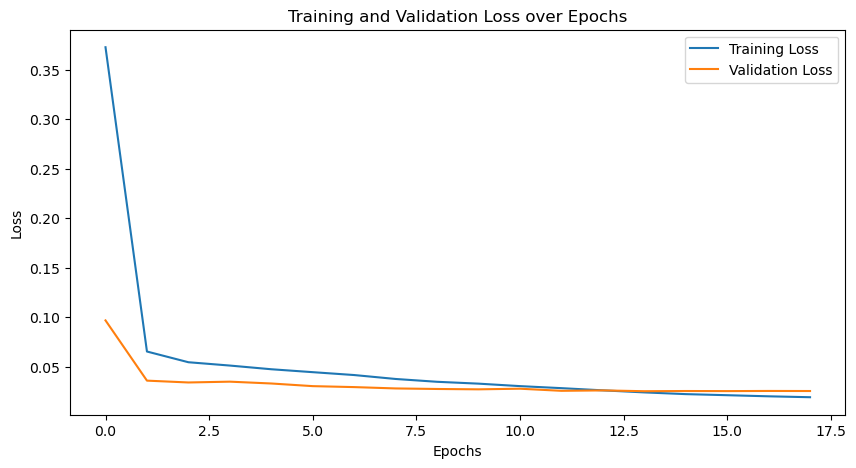

Finished Training


In [123]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

print('Finished Training')

## Evaluación y Predicción en el conjunto de Test

1. **Evaluación de las predicciones**:
Se pone el modelo en modo `eval()` y se itera sobre el conjunto de validación para obtener las predicciones y se calcula el F1 usando el mejor umbral.

2. **Preparación del conjunto de Test**:
Se crea la clase `BirdSongTestDataset` que lee de `test.csv`, y se crea un DataLoader para el conjunto de Test.

3. **Predicciones en el conjunto de Test**:
Se itera sobre el conjunto de test y se obtienen las predicciones del modelo para cada archivo de audio. Se binarizan usando el mejor umbral y se almacenan en un diccionario con el nombre del archivo como clave.
Las predicciones se convierten en un DataFrame de Pandas y se preparan los datos en el formato esperado, y por último se guarda el DataFrame en un archivo CSV.

In [124]:
print(f"Best threshold: {best_threshold_val}")

Best threshold: 0.30000000000000004


In [125]:
model.eval()
audio_preds = defaultdict(list)
audio_labels = defaultdict(list)

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(valid_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > best_threshold_val).float()

        # Fetch the filename for each segment
        for i, (input_, label, pred) in enumerate(zip(inputs, labels, preds)):
            # Compute the correct index in the dataset
            dataset_index = batch_idx * valid_loader.batch_size + i
            filename = valid_dataset.get_filename(dataset_index)
            audio_preds[filename].append(pred.cpu().numpy())
            # The label should be the same for all segments of the same audio, so we append it only once
            if filename not in audio_labels:
                audio_labels[filename] = label.cpu().numpy()

# Aggregating the segment-level predictions for each audio to generate a single prediction for the whole audio
for filename in audio_preds:
    # Here, we take the max prediction for each class across all segments as the audio-level prediction
    audio_preds[filename] = np.maximum.reduce(audio_preds[filename])

all_labels = list(audio_labels.values())
all_preds = list(audio_preds.values())

f1_macro = f1_score(all_labels, all_preds, average='samples', zero_division=1)
print(f"F1 Score (Samples): {f1_macro}")


F1 Score (Samples): 0.5266666666666666


In [126]:
class BirdSongTestDataset(Dataset):
    def __init__(self, df, audio_dir, transform=None):
        segments = []

        unique_filenames = df['filename'].unique()
        for unique_filename in unique_filenames:
            audio_path = os.path.join(audio_dir, unique_filename)
            waveform, sample_rate = torchaudio.load(audio_path)
            total_segments = int(math.ceil(waveform.shape[1] / sample_rate))

            for idx in range(total_segments):
                start_time, end_time = idx, idx + 1
                segments.append({
                    'filename': unique_filename, 
                    'segment_idx': idx, 
                    'start': start_time, 
                    'end': end_time,
                })

        self.segments = pd.DataFrame(segments)
        self.audio_dir = audio_dir
        self.transform = transform

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        row = self.segments.iloc[idx]
        audio_path = os.path.join(self.audio_dir, row['filename'])
        waveform, sample_rate = torchaudio.load(audio_path)

        start_sample = int(row['start'] * sample_rate)
        end_sample = int(row['end'] * sample_rate)
        waveform = waveform[:, start_sample:end_sample]

        if waveform.shape[1] < sample_rate:
            num_padding = sample_rate - waveform.shape[1]
            waveform = torch.cat([waveform, torch.zeros(1, num_padding)], dim=1)

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, row['filename'], row['segment_idx']


# Load the test CSV
test_csv = pd.read_csv(f'{base_path}data/test.csv')

def collate_fn(batch):
    # Extracting tensors from the first item of the data point
    segments = [item[0][0] for item in batch]  # Accessing the tensor in the tuple
    
    # Extracting filenames
    filenames = [item[1] for item in batch]
    
    # Stacking tensors
    segments_tensor = torch.stack(segments, dim=0)
    
    return segments_tensor, filenames


test_dataset = BirdSongTestDataset(test_csv, f'{base_path}data/test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


nips4b_test149.wav
torch.Size([1, 128, 226])
Processing original_spectrograms with shape torch.Size([1, 128, 226])


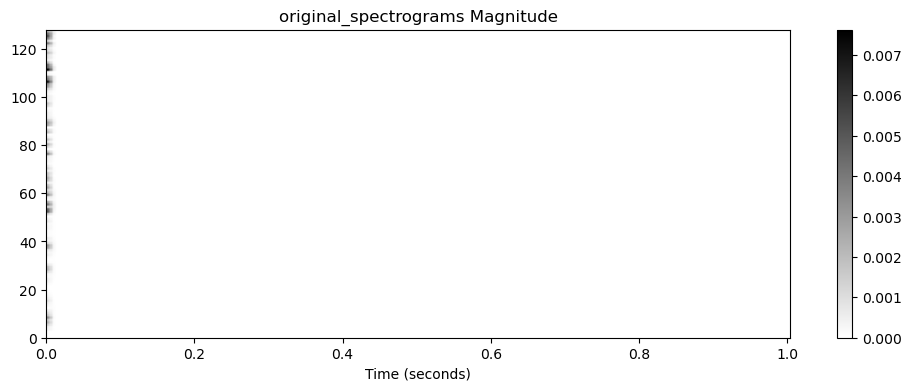

Processing spectrograms_after_median_blurring with shape torch.Size([1, 128, 226])


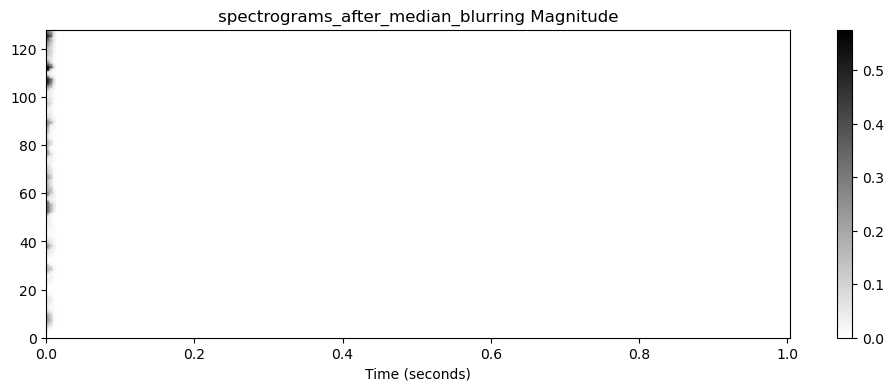

Processing spectrograms_after_median_filtering with shape torch.Size([1, 128, 226])


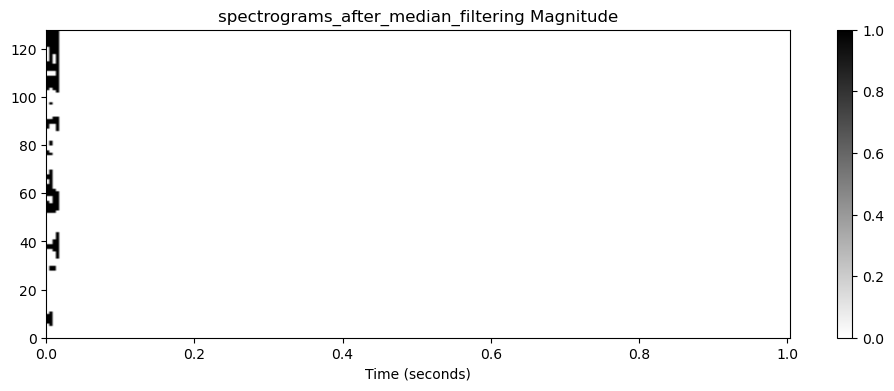

Processing spectrograms_after_morph_closing with shape torch.Size([1, 128, 226])


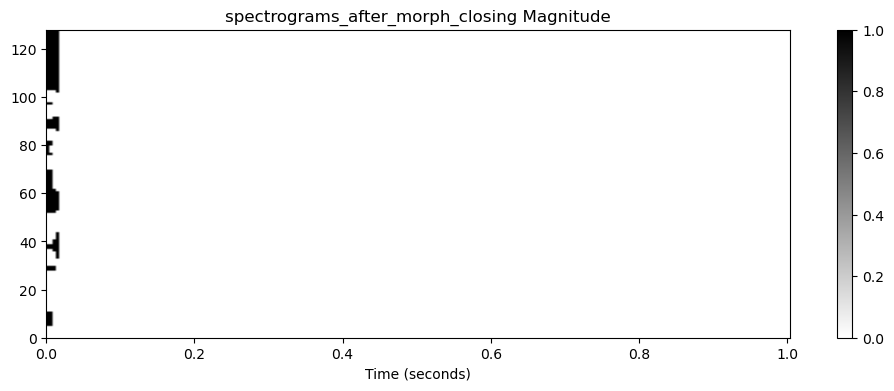

In [127]:
if DEBUG:
  (sample, intermediates), filename, label = test_dataset[-1]
  print(filename)
  print(sample.shape)
  visualize_intermediates(intermediates)

In [128]:
# Make predictions on test set
model.eval()
predictions = defaultdict(lambda: np.zeros(len(class_names), dtype=bool))  # Changed dtype to bool for logical OR operation

with torch.no_grad():
    for inputs, filenames in test_loader: # Fixed this line
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.1).float().cpu().numpy().astype(bool)
        
        for fname, pred in zip(filenames, preds):
            # Use logical OR to aggregate predictions for each audio
            predictions[fname] = np.logical_or(predictions[fname], pred)

# Convert boolean values to integer (0 or 1)
for key in predictions:
    predictions[key] = predictions[key].astype(int)

submission_df = pd.DataFrame.from_dict(predictions, orient='index', columns=class_names)
submission_df.reset_index(inplace=True)
submission_df.rename(columns={'index': 'filename'}, inplace=True)
submission_df.to_csv('submission.csv', index=False)
